In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps
from sklearn import linear_model
import os
os.chdir('../')

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [3]:
inc_val = 0.0
inc_std = 0.25

D = 4
lb = -5.*np.ones((D,))
ub = 5.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

alpha_betas = ['E_P', 'E_S']
num_abs = len(alpha_betas)

In [4]:
def hp_df_to_nf(hp_df):
    nf = NormalizingFlow(
        arch_type=hp_df['arch_type'],
        D=model.D,
        num_stages=int(hp_df['num_stages']),
        num_layers=int(hp_df['num_layers']),
        num_units=int(hp_df['num_units']),
        batch_norm=bool(hp_df['batch_norm']),
        bn_momentum=float(hp_df['bn_momentum']),
        post_affine=bool(hp_df['post_affine']),
        bounds=model._get_bounds(),
        random_seed=int(hp_df['random_seed']),
    )
    return nf

def hp_df_to_aug_lag_hps(hp_df):
    aug_lag_hps = AugLagHPs(
        N=int(hp_df['N']), 
        lr=hp_df['lr'], 
        c0=hp_df['c0'], 
        gamma=hp_df['gamma'], 
        beta=hp_df['beta'],
    )
    return aug_lag_hps

In [5]:
nus = [1., 1.]

opt_dfs = []
hp_df_rows = []
best_ks = []
for j in range(num_abs):
    alpha_beta_str = alpha_betas[j]
    name = "V1Circuit_%s" % alpha_beta_str
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)
    
    if alpha_beta_str == 'E_P':
        b = np.array([1., -5., 1., 1.25])
    elif alpha_beta_str == 'E_S':
        b = np.array([1., 1., -5., 1.25])
    else:
        break
        

    dr = V1_dr_eps('E', inc_val, b=b)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    hp_df, opt_df = model.get_epi_dfs(mu, prefix='V1Circuit/')
    opt_dfs.append(opt_df)
    best_ind = 0
    maxH = None
    i = 0
    best_k = -1
    for _, hp_df_i in hp_df.iterrows():
        nf = hp_df_to_nf(hp_df_i)
        aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_i)
        k, conv, H = model.get_convergence_epoch(
            mu, 
            nf, 
            aug_lag_hps, 
            prefix='V1Circuit/', 
            nu=nus[j], 
        )
        if (conv and ((maxH is None) or H > maxH)):
            best_ind = i
            maxH = H
            best_k = k
            
        i += 1
        
    best_ks.append(best_k)
    hp_df_rows.append(hp_df.iloc[best_ind])


Checking in V1Circuit/data/V1Circuit_E_P_dr_mu=0.00E+00_6.25E-02/.
skipping V1Circuit/data/V1Circuit_E_P_dr_mu=0.00E+00_6.25E-02/temp/hps.p
Found 1 optimizations.
ckpt_dir
V1Circuit/data/V1Circuit_E_P_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs2_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
[0. 0.] 0.025
[0. 0.] 0.025
[0. 0.] 0.025
[0. 0.] 0.025
[0.03 0.  ] 0.025
[0. 0.] 0.025
[0.15 0.  ] 0.025
[0.51 0.  ] 0.025
[0.9  0.85] 0.025
Checking in V1Circuit/data/V1Circuit_E_S_dr_mu=0.00E+00_6.25E-02/.
skipping V1Circuit/data/V1Circuit_E_S_dr_mu=0.00E+00_6.25E-02/temp/hps.p
Found 1 optimizations.
ckpt_dir
V1Circuit/data/V1Circuit_E_S_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs3_N500_lr1.00E-03_c0=1.00E+00_gam

In [7]:
q_thetas = []
for i in range(num_abs):
    alpha_beta_str = alpha_betas[i]
    hp_df_row = hp_df_rows[i]

    name = "V1Circuit_%s" % alpha_beta_str
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)
    
    if alpha_beta_str == 'E_P':
        b = np.array([1., -5., 1., 1.25])
    elif alpha_beta_str == 'E_S':
        b = np.array([1., 1., -5., 1.25])
    else:
        break

    dr = V1_dr_eps('E', inc_val, b=b)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    nf = hp_df_to_nf(hp_df_row)
    aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_row)
    q_theta = model.load_epi_dist(
        best_ks[i],
        mu,
        nf,
        aug_lag_hps,
        prefix='V1Circuit/',
    )
    q_thetas.append(q_theta)

ckpt_dir
V1Circuit/data/V1Circuit_E_P_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs2_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
ckpt_dir
V1Circuit/data/V1Circuit_E_S_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs3_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/


In [8]:
z1s = [np.array([[1., 3., 0., 0.],
                 #[0., -3., 0., 0.],
                 [3., 2., 4.2, 0.]]),
       np.array([[0., 1.5, .75, 0.]]),
       np.array([[3., 0., -1., -2.]]),
       np.array([[0., 3., 1., 1.]])
      ]
c_traj = np.array([[0., 0., 0.],
                   [0.7, 0.7, 0.7],
                   [0.4, 0.4, 0.4]])  

ckpt_dir
V1Circuit/data/V1Circuit_E_P_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs2_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
ckpt_dir
V1Circuit/data/V1Circuit_E_S_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs3_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/


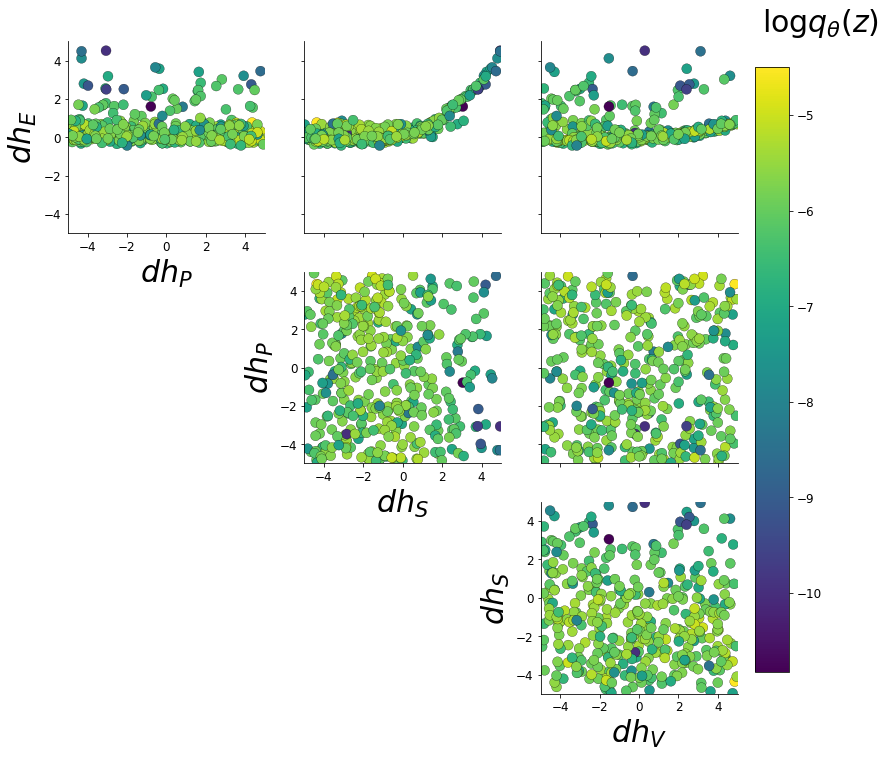

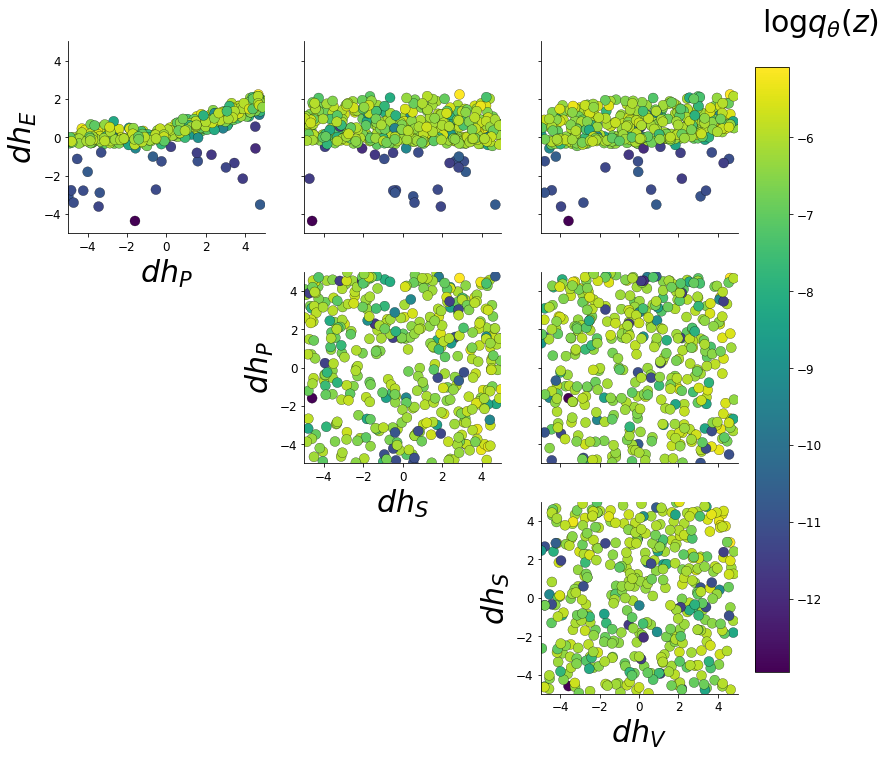

In [9]:
vs = []
T_xs = []
for i in range(num_abs):
    alpha_beta = alpha_betas[i]
    hp_df_row = hp_df_rows[i]

    name = "V1Circuit_%s" % alpha_beta
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)
    
    if alpha_beta_str == 'E_P':
        b = np.array([1., -5., 1., 1.25])
    elif alpha_beta_str == 'E_S':
        b = np.array([1., 1., -5., 1.25])
    else:
        break

    dr = V1_dr_eps('E', inc_val, b=b)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    nf = hp_df_to_nf(hp_df_row)
    aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_row)
    q_theta = model.load_epi_dist(
        best_ks[i],
        mu,
        nf,
        aug_lag_hps,
        prefix='V1Circuit/',
    )
    
    # Get samples
    _N = 10000
    n_plot = 400
    z = q_theta.sample(_N)
    log_prob = q_theta.log_prob(z)
    T_x = model.eps(z).numpy()
    T_xs.append(T_x)
    
    """z1 = z1s[i]
    z2 = np.zeros_like(z1)
    num_zs = z1.shape[0]
    _vs = []
    for j in range(num_zs):
        hess = q_theta.hessian(z1[j][None,:])[0]
        d, v = np.linalg.eig(hess)
        eigsort = np.argsort(d)
        v = v[:,eigsort]
        v_sens = v[:,0]
        if v_sens[0] < 0:
            v_sens = -v_sens
        z2[j] = z1[j] + 2*v_sens[None,:]
        _vs.append(v_sens)
    vs.append(_vs)"""
    

    dims = range(D)
    z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
    fig = pairplot(z[:n_plot], dims, z_labels,
       #z1=z1, z2=z2,
       xlims=[-5, 5], ylims=[-5, 5],
       c_label = r'$\log q_\theta(z)$',
       c=log_prob, fontsize=30,
       #c_traj=c_traj,
    )

In [76]:
zs = []
vs = []
for i in range(num_abs):
    alpha_beta = alpha_betas[i]
    hp_df_row = hp_df_rows[i]

    name = "V1Circuit_%s" % alpha_beta
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)
    
    if alpha_beta_str == 'E_P':
        b = np.array([1., -5., 1., 1.25])
    elif alpha_beta_str == 'E_S':
        b = np.array([1., 1., -5., 1.25])
    else:
        break

    dr = V1_dr_eps('E', inc_val, b=b)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    nf = hp_df_to_nf(hp_df_row)
    aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_row)
    q_theta = model.load_epi_dist(
        best_ks[i],
        mu,
        nf,
        aug_lag_hps,
        prefix='V1Circuit/',
    )
    
    # Get samples
    n_keep = 500
    z = q_theta.sample(n_keep)
    zs.append(z)
    
    _vs = []
    for j in range(n_keep):
        print('%3d/%d\r' % (j+1, n_keep), end='')
        hess = q_theta.hessian(z[j][None,:])[0]
        d, v = np.linalg.eig(hess)
        eigsort = np.argsort(d)
        v = v[:,eigsort]
        v_sens = v[:,0]
        _vs.append(v_sens)
    vs.append(_vs)
vs = np.array(vs)  

ckpt_dir
V1Circuit/data/V1Circuit_E_P_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs2_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
ckpt_dir
V1Circuit/data/V1Circuit_E_S_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs3_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/


In [77]:
npzfile = np.load('E_sens_vecs.npz')
E_vs = npzfile['E_vecs']
num_E_vecs = E_vs.shape[0]

In [78]:
cosines = np.zeros((num_abs, num_E_vecs, n_keep,))
for k in range(num_abs):
    for i in range(num_E_vecs):
        E_v = E_vs[i]
        for j in range(n_keep):
            v_j = vs[k,j]
            cosines[k,i,j] = np.dot(E_v, v_j)
print(cosines)

[[[-0.47662213 -0.87991816 -0.88943356 ... -0.89676344  0.88584912
   -0.89112234]
  [-0.95686948 -0.85225391 -0.84082758 ... -0.80862534  0.84080499
   -0.8353129 ]]

 [[-0.91968548 -0.96021956 -0.95442438 ...  0.88385648 -0.93282884
   -0.89298797]
  [-0.83658236 -0.85885513 -0.8852641  ...  0.69327414 -0.70373648
   -0.82669085]]]


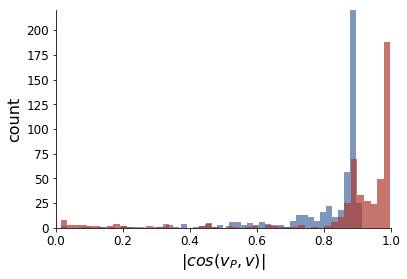

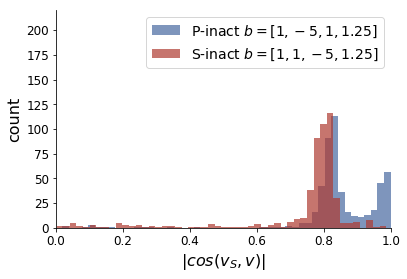

In [98]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [blue, red]

xlabels = [r'$|cos(v_P, v)|$', r'$|cos(v_S, v)|$']
legend_strs = [r'P-inact $b = [1, -5, 1, 1.25]$', r'S-inact $b = [1, 1, -5, 1.25]$']
for i in range(num_E_vecs):
    plt.figure()
    for j in range(num_abs):
        plt.hist(np.abs(cosines[j,i]), 50, color=colors[j], alpha=0.7)
    plt.xlim([0, 1])
    plt.ylim([0, 220])
    plt.xlabel(xlabels[i])
    plt.ylabel('count')
    if (i==1):
        plt.legend(legend_strs)
    plt.show()

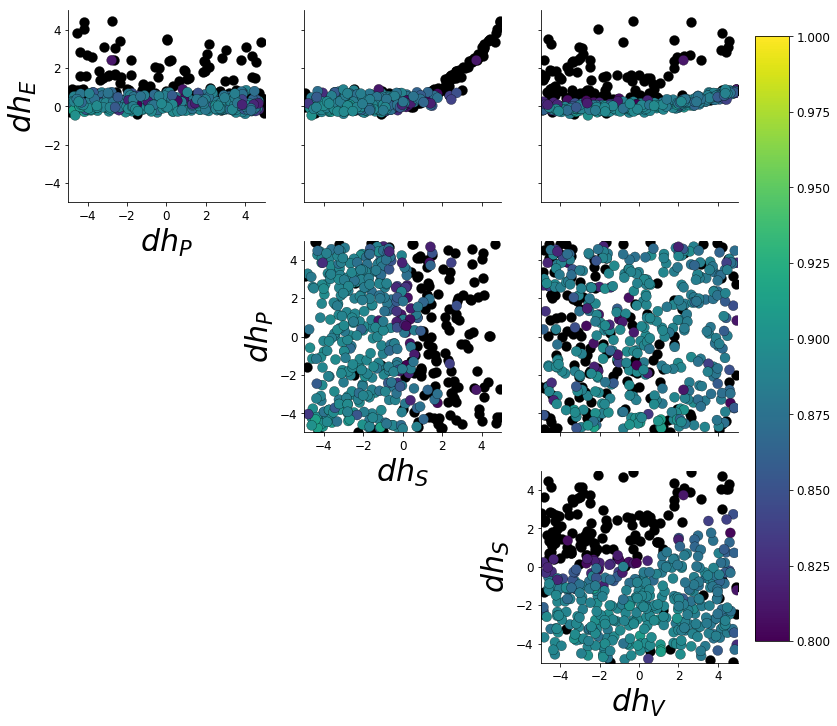

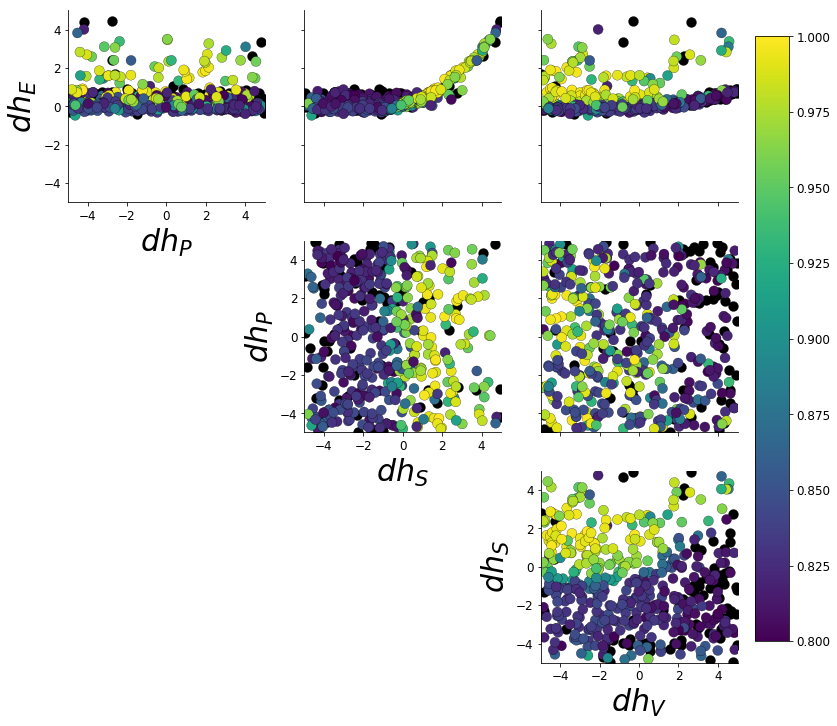

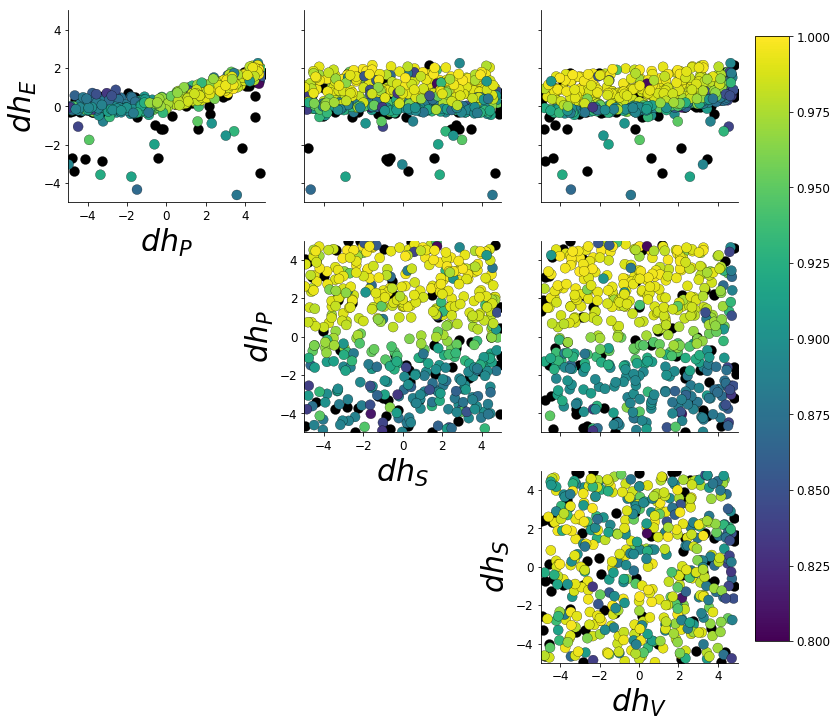

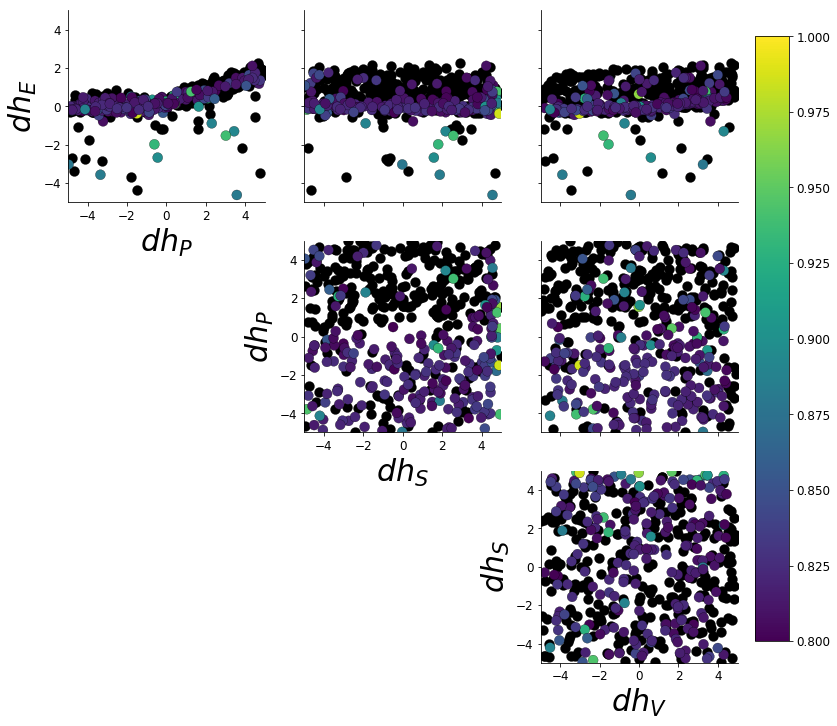

In [87]:
vs = []
for i in range(num_abs):
    for j in range(num_E_vecs):
        dims = range(D)
        z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
        fig = pairplot(zs[i], dims, z_labels,
           xlims=[-5, 5], ylims=[-5, 5], clims=[.8, 1.],
           c_label = '',
           c=np.abs(cosines[i][j]), fontsize=30,
           #c_traj=c_traj,
        )